In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoConfig, TrainingArguments, Trainer,AutoModelForSeq2SeqLM
from datasets import load_dataset
from peft import LoraConfig

In [2]:
peft_config = LoraConfig(
    r=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",)

In [3]:
dataset = load_dataset("pszemraj/booksum-short")

In [4]:
quantization_config = BitsAndBytesConfig(
        #load_in_8bit= False,
        load_in_4bit=True,
        # llm_int8_enable_fp32_cpu_offload=True,
        # llm_int8_has_fp16_weight=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype="float16"
)

In [5]:
device = 'cuda'

In [6]:
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn")

In [7]:
model.add_adapter(peft_config, adapter_name="chapter_adapter")

In [8]:
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")

In [9]:

chapter_len = [len(x['chapter'].split()) for x in dataset['train']]
summary_len = [len(x['summary_text'].split()) for x in dataset['train']]

array([[<Axes: title={'center': 'Chapter Length'}>,
        <Axes: title={'center': 'Summary Length'}>]], dtype=object)

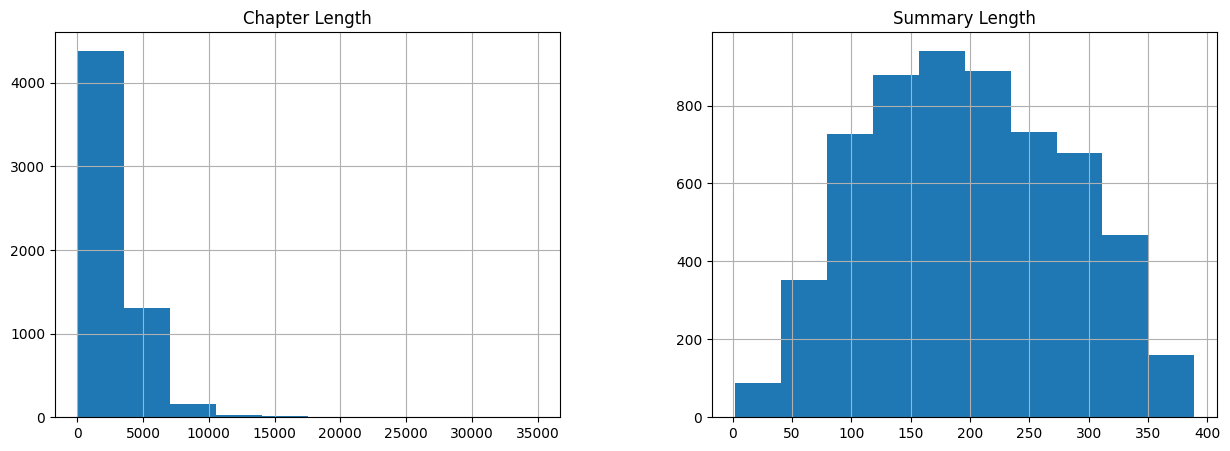

In [10]:

import pandas as pd

data = pd.DataFrame([chapter_len, summary_len]).T
data.columns = ['Chapter Length', 'Summary Length']

data.hist(figsize=(15,5))

In [11]:

# lets build Data Collator

def get_feature(batch):
  encodings = tokenizer(batch['chapter'], text_target=batch['summary_text'],
                        max_length=1024, truncation=True)

  encodings = {'input_ids': encodings['input_ids'],
               'attention_mask': encodings['attention_mask'],
               'labels': encodings['labels']}

  return encodings

In [12]:
dataset_pt = dataset.map(get_feature, batched=True)

Map:   0%|          | 0/1012 [00:00<?, ? examples/s]

In [13]:
dataset_pt

DatasetDict({
    train: Dataset({
        features: ['bid', 'is_aggregate', 'source', 'chapter_path', 'summary_path', 'book_id', 'summary_id', 'content', 'summary', 'chapter', 'chapter_length', 'summary_name', 'summary_url', 'summary_text', 'summary_analysis', 'summary_length', 'analysis_length', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 5912
    })
    validation: Dataset({
        features: ['bid', 'is_aggregate', 'source', 'chapter_path', 'summary_path', 'book_id', 'summary_id', 'content', 'summary', 'chapter', 'chapter_length', 'summary_name', 'summary_url', 'summary_text', 'summary_analysis', 'summary_length', 'analysis_length', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1012
    })
    test: Dataset({
        features: ['bid', 'is_aggregate', 'source', 'chapter_path', 'summary_path', 'book_id', 'summary_id', 'content', 'summary', 'chapter', 'chapter_length', 'summary_name', 'summary_url', 'summary_text', 'summary_analysis', 'summary_length', 'a

In [14]:
columns = ['input_ids', 'labels', 'attention_mask']
dataset_pt.set_format(type='torch', columns=columns)

In [15]:

from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [16]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir = 'mistral_dataset',
    num_train_epochs=1,
    warmup_steps = 500,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay = 0.01,
    logging_steps = 10,
    evaluation_strategy = 'steps',
    eval_steps=500,
    save_steps=1e6,
    gradient_accumulation_steps=16
)

trainer = Trainer(model=model, args=training_args, tokenizer=tokenizer, data_collator=data_collator,
                  train_dataset = dataset_pt['train'], eval_dataset = dataset_pt['validation'])

In [17]:

trainer.train()

C:\Users\yferc\anaconda3\envs\projet-annuel\Lib\site-packages\transformers\models\bart\modeling_bart.py:587: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Step,Training Loss,Validation Loss


TrainOutput(global_step=92, training_loss=3.440512797106867, metrics={'train_runtime': 1466.5048, 'train_samples_per_second': 4.031, 'train_steps_per_second': 0.063, 'total_flos': 1.282392408981504e+16, 'train_loss': 3.440512797106867, 'epoch': 0.9959404600811907})

In [19]:
trainer.save_model('models/bart_model_v1')

C:\Users\yferc\anaconda3\envs\projet-annuel\Lib\site-packages\transformers\integrations\peft.py:391: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(
